In [19]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.utils import to_categorical
from PIL import Image
import os
import pandas as pd

import matplotlib.pyplot as plt

In [20]:
global dfO
dfO = pd.DataFrame(columns=["Time", "Res_Freq", "Amplitude", "Phase", "Sample_number", "Peak", "Before_compression", "After_compression", "Compression_ratio", "Compression_time"])

In [21]:
def reload_data(debug=False):
    #deep copy of dfO
    df = dfO.copy(deep=True)
    # for each sample in data_/Snail/<folder>/<name>.txt open the txt file and append the data to a pandas dataframe
    file_loaded = 0

    for root, dirs, files in os.walk("../data_/Snail"):
        for name in files:
            if name.endswith(".txt"):
                file_path = os.path.join(root, name)
                sample_number = root.split("_")[-1]
                with open(file_path, "r") as f:
                    lines = f.readlines()
                
                file_loaded += 1

                header_index = lines.index("X_Value\tTime\tRes.Frequency\tAmplitude\tPhase\tComment\n")
                data_rows = lines[header_index+1:]

                data_values = [line.strip().split('\t')[:] for line in data_rows]
                #add the sample number to the data_values :
                # from [['0.050003', '1448.050731', '27.196000', '-5.780000'], ['0.150009', '1448.060841', '27.192000', '-5.720000'],..]
                # to [['0.050003', '1448.050731', '27.196000', '-5.780000', sample_number], ['0.150009', '1448.060841', '27.192000', '-5.720000', sample_number],..]
                #data_values = [row + [sample_number] for row in data_values]
                
                
                df_new = pd.DataFrame(data_values, columns=["Time", "Res_Freq", "Amplitude", "Phase"])

                df_new["Sample_number"] = sample_number
                df_new["Peak"] = 0
                df_new["Before_compression"] = 0
                df_new["After_compression"] = 0
                df_new["Compression_ratio"] = 0
                df_new["Compression_time"] = 0

            

                df = pd.concat([df, df_new], ignore_index=True)


    df.astype({"Time": float, "Res_Freq": float, "Amplitude": float, "Phase": float, "Sample_number": int,
               "Peak": int, "Before_compression": int, "After_compression": int,
               "Compression_ratio": float, "Compression_time": float})
    
    df = df.apply(pd.to_numeric, errors='coerce')


    if debug:
        print("Files loaded: ", file_loaded)
        print("df shape: ", df.shape)
        # print("df head:\n",df.head())
    return df

df = reload_data(debug=False)


In [22]:
def drop_outliers(options_outliers:dict=None, debug=False):
    df = reload_data(debug)

    options_default = {"Res_Freq_min": 1000, "Res_Freq_max": 5000,
                "Amplitude_min": None, "Amplitude_max": 40,
                "Phase_min": None, "Phase_max": None,
                "interval_df" : [1350, 1600], "downsampling_rate" : 0.02}
    
    if options_outliers is not None:
        if debug: print("options received:" , options_outliers)
        for key in options_default.keys():
            if key in options_outliers.keys():
                options_default[key] = options_outliers[key]
        options_outliers = options_default
    else:
        options_outliers = options_default


    df = df.dropna()
    if debug: print("dfs-> dropna: ", df.shape)

    #drop duplicates
    df = df.drop_duplicates()
    if debug: print("dfs-> drop_duplicates: ", df.shape)


    #drop nan  in Res_Freq
    df = df[df.Res_Freq.notnull()]
    if debug: print(f"dfs-> dropna in Res_Freq: {df.shape}")

    

    # drop outliers in Res_Freq

    if options_outliers["Res_Freq_min"] is not None:
        df = df[df.Res_Freq > options_outliers["Res_Freq_min"]]
    if options_outliers["Res_Freq_max"] is not None:
        df = df[df.Res_Freq < options_outliers["Res_Freq_max"]]
        
    if debug: print(f"dfs-> outliers in Res_Freq [{options_outliers['Res_Freq_min']}:{options_outliers['Res_Freq_max']}] : {df.shape}")

    # drop outliers in Amplitude
    if options_outliers["Amplitude_min"] is not None:
        df = df[df.Amplitude > options_outliers["Amplitude_min"]]
    if options_outliers["Amplitude_max"] is not None:
        df = df[df.Amplitude < options_outliers["Amplitude_max"]]
    if debug: print(f"dfs-> outliers in Amplitude [{options_outliers['Amplitude_min']}:{options_outliers['Amplitude_max']}] : {df.shape}")

    # drop outliers in Phase
    if options_outliers["Phase_min"] is not None:
        df = df[df.Phase > options_outliers["Phase_min"]]
    if options_outliers["Phase_max"] is not None:
        df = df[df.Phase < options_outliers["Phase_max"]]
    if debug: print(f"dfs-> outliers in Phase [{options_outliers['Phase_min']}:{options_outliers['Phase_max']}] : {df.shape}")


    # reduce the number of data points in the interval [1350, 1600] of Res_Freq
    start = options_outliers["interval_df"][0]
    end = options_outliers["interval_df"][1]

    # Filter the dataframe to include values within the specified interval
    interval_df = df[(df['Res_Freq'] >= start) & (df['Res_Freq'] <= end)]

    downsampling_rate = options_outliers["downsampling_rate"]
    downsampled_df = interval_df.sample(frac=downsampling_rate, random_state=1)

    df = pd.concat([df[~((df['Res_Freq'] >= start) & (df['Res_Freq'] <= end))], downsampled_df])

    if debug: print(f"dfs-> downsampling at {downsampling_rate*100}% in [{start}: {end}]: {df.shape}")
        

    #print max value of Res_Freq for each sample
    #print("max Res_Freq for each sample:\n", df.groupby("Sample_number")["Res_Freq"].max())
    return df

df = drop_outliers(debug=False, options_outliers=None)

In [23]:
def get_longest_peak_intrvl_Res_Freq(options_get_peak: dict = None, options_outliers: dict = None, debug=False):
    df = drop_outliers(options_outliers, debug)
    
    options_default = {"interval_scnd": 25, "peak_freq": 1600}
    
    if options_get_peak is not None:
        if debug: print("options received:" , options_get_peak)
        for key in options_default.keys():
            if key in options_get_peak.keys():
                options_default[key] = options_get_peak[key]
        options_get_peak = options_default
    else:
        options_get_peak = options_default


    # isolate each peak of Res_Freq (the frequency needs to go below 1550 before going up again) for each sample
    for i in range(1, df["Sample_number"].max() + 1):
        df_sample = df[df["Sample_number"] == i]
        
        # Sort the values by time (type numpy.float64)
        df_sample = df_sample.sort_values(by="Time")

        
        # Find all the peaks
        peaks = []
        peak_start = None
        
        for j in range(1, len(df_sample) - 1):
            if df_sample["Res_Freq"].iloc[j] > options_get_peak["peak_freq"] and df_sample["Res_Freq"].iloc[j - 1] <= options_get_peak["peak_freq"]: #and df_sample["Res_Freq"].iloc[j + 1] >= 1550:
                if peak_start is None:
                    peak_start = df_sample["Time"].iloc[j]
                    # print(f"(>) Peak start: {peak_start} (Sample {i})")
            
            elif df_sample["Res_Freq"].iloc[j] <= options_get_peak["peak_freq"] and df_sample["Res_Freq"].iloc[j - 1] > options_get_peak["peak_freq"]:# and df_sample["Res_Freq"].iloc[j + 1] < 1550:
                if peak_start is not None:
                    # print(f"Peak end: {df_sample['Time'].iloc[j]} (Sample {i})")
                    peak_end = df_sample["Time"].iloc[j]
                    peaks.append([peak_start, peak_end])
                    peak_start = None
        
        #if debug: print(f"Peaks Sample {i}: {peaks}")

        #compressio_Time = addition of all the time between the start and end of each peak
        compression_Time = 0
        for peak in peaks:
            compression_Time += peak[1] - peak[0]
        if debug: print(f"Sample {i} - Compression time: {compression_Time}")
        # add it to the dataframe
        df.loc[df["Sample_number"] == i, "Compression_time"] = compression_Time

        # # Find the longest peak
        longest_peak = max(peaks, key=lambda p: p[1] - p[0]) if peaks else None

        # Add 10 seconds before and after the longest peak
        if longest_peak:
            # get the rows of the longest peak (find the index the most close to the start and end of the peak +- interval_scnd)
            start_time = df_sample.iloc[(df_sample["Time"] - longest_peak[0]).abs().argsort()[:1]].iloc[0]["Time"] - options_get_peak["interval_scnd"]
            end_time = df_sample.iloc[(df_sample["Time"] - longest_peak[1]).abs().argsort()[:1]].iloc[0]["Time"] + options_get_peak["interval_scnd"]
            if debug:
                print(f"Sample {i} - Longest peak: {longest_peak}, Interval: {start_time} - {end_time} (out of {len(peaks)} peaks)")
            # Perform further operations with the interval
            # add Peak = 1 on df if the row is in the interval
            df.loc[(df["Sample_number"] == i) & (df["Time"] >= start_time) & (df["Time"] <= end_time), "Peak"] = 1

    return df

#df_peak = get_longest_peak_intrvl_Rez_Freq(interval_scnd=30, peak_freq=1550, options_outliers={"downsampling_rate": 1}, debug=False)


In [24]:
def get_df(option_get_df: dict=None, options_get_peak: dict=None, options_outliers: dict=None, debug=False):

    options_default = {"type": None}
    
    if option_get_df is not None:
        if debug: print("options received:" , option_get_df)
        for key in options_default.keys():
            if key in option_get_df.keys():
                options_default[key] = option_get_df[key]
        option_get_df = options_default
    else:
        option_get_df = options_default

    if option_get_df["type"] == "raw":
        df = drop_outliers(options_outliers, debug)

    elif option_get_df["type"] == "peak":
        df = get_longest_peak_intrvl_Res_Freq(options_get_peak,
                                                options_outliers,
                                                debug)
    else:
        df = get_longest_peak_intrvl_Res_Freq(options_get_peak,
                                                options_outliers,
                                                debug)

    return df

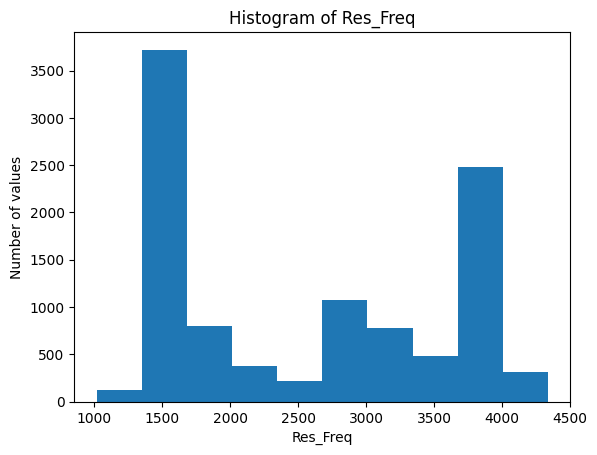

In [26]:
def plot_data_repartition(debug=False, options_outliers:dict=None):
    df = drop_outliers(options_outliers, debug)
    
    plt.hist(df["Res_Freq"], bins=10)  # Adjust the number of bins as needed

    # Set labels for x-axis and y-axis
    plt.xlabel("Res_Freq")
    plt.ylabel("Number of values")

    # Set a title for the plot
    plt.title("Histogram of Res_Freq")

    # Display the plot
    plt.show()


plot_data_repartition()

In [27]:
def plot_boxplot(column_to_plot:list, debug=False, options_outliers:dict=None):
    df = drop_outliers(options_outliers, debug)
    df.boxplot(column=column_to_plot, by="Sample_number", figsize=(20,10))

#plot_boxplot(["Res_Freq"])

In [28]:
#df.plot.scatter(x="Time", y="Res_Freq", c="Sample_number", colormap="viridis")
# plot only for one sample
#df[df["Sample_number"] == 1].plot.scatter(x="Time", y="Res_Freq")

def plot_time_vs_Res_Freq_vs_Amplitude(sample_numbers=False, df=False, options_plot=None, 
                                       option_get_peak: dict = None,
                                       options_outliers: dict = None, debug=False,):
    options_default = {"type": None}
    
    if options_plot is not None:
        if debug: print("options received:" , options_plot)
        for key in options_default.keys():
            if key in options_plot.keys():
                options_default[key] = options_plot[key]
        options_plot = options_default
    else:
        options_plot = options_default



    # if df is not provided, reload the data (if type != false)
    if type(df) != pd.DataFrame:
        option_get_df = {"type": None}

        if options_plot["type"] == "raw":
            option_get_df["type"] = "raw"
            
        df = get_df(option_get_df, option_get_peak, options_outliers, debug)
    

    if not sample_numbers:
        sample_numbers = [1]
        
    num_samples = len(sample_numbers)
    fig, axs = plt.subplots(num_samples, 1, figsize=(8, 3*num_samples))  # Adjust the figsize parameter for smaller size

    for i, sample_number in enumerate(sample_numbers):
        # deep copy of the dataframe
        df_copy = df.copy()
        # Drop outliers and filter the dataframe based on the sample_number
        df_sample = df_copy[df_copy["Sample_number"] == sample_number]

        if options_plot["type"] == "peak":
            df_sample = df_sample[df_sample["Peak"] == 1]
            

        # if no data print then pass to next sample

        if df_sample.shape[0] == 0:
            print(f"No data for sample for: {sample_number}")
            continue
            
        
        # Extract the relevant columns
        time = df_sample["Time"]
        res_freq = df_sample["Res_Freq"]
        amplitude = df_sample["Amplitude"]

        

        # Sort the values of time
        time, res_freq, amplitude = zip(*sorted(zip(time, res_freq, amplitude)))

        # Plot the lines on separate subplots
        ax = axs[i] if num_samples > 1 else axs  # Use the respective subplot
        color1 = 'tab:red'
        ax.plot(time, res_freq, color=color1, label="Freq (s{})".format(sample_number))
        ax.set_xlabel("Time")
        ax.set_ylabel("Frequency", color=color1)
        ax.tick_params(axis='y', labelcolor=color1)
        ax.legend(loc="upper left")

        ax2 = ax.twinx()  # Create a separate y-axis for amplitude
        color2 = 'tab:blue'
        ax2.plot(time, amplitude, color=color2, label="Amp (s{})".format(sample_number))
        ax2.set_ylabel("Amplitude", color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.legend(loc="upper right")

    # Set a common title for the plot
    title = "Time vs Frequency vs Amplitude"
    if options_plot["type"]:
        title += f" ({options_plot['type']})"
    fig.suptitle(title)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()
    
    

#plot_time_vs_Res_Freq_vs_Amplitude([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
#plot_time_vs_Res_Freq_vs_Amplitude([4], debug=True, options_outliers={"Res_Freq_min": None, "Res_Freq_max": None, "Amplitude_max": None, "downsampling_rate": 0.1})




In [29]:
def plot_compression_time(df=False, option_get_peak: dict = None,
                            options_outliers: dict = None, debug=False):


    # if df is not provided, reload the data (if type != false)
    if type(df) != pd.DataFrame:
        option_get_df = {"type": "peak"}
        df = get_df(option_get_df, option_get_peak, options_outliers, debug)
    
    # take one Compression_time for each sample
    df = df.groupby("Sample_number").first().reset_index()
    df = df[["Sample_number", "Compression_time"]]
    df = df.sort_values(by="Sample_number")

    # plot
    plt.plot(df["Sample_number"], df["Compression_time"])
    plt.xlabel("Sample number")
    plt.ylabel("Compression time")
    plt.title("Compression time vs Sample number")
    plt.show()
    

In [31]:

df_peak = get_df(option_get_df={"type": "peak"})

graph_to_plot = [1]
#plot_time_vs_Res_Freq_vs_Amplitude(graph_to_plot, options_plot={"type" : "raw"})
#plot_time_vs_Res_Freq_vs_Amplitude(graph_to_plot, options_plot= {"type" : "peak"})

#plot_compression_time(df=df_peak)